In [4]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

## Import facility data and NERC labels

In [164]:
path = os.path.join('Data storage', 'Facility gen fuels and CO2 2017-05-25.zip')
facility_df = pd.read_csv(path, parse_dates=['datetime'])

In [18]:
facility_df.head()

,f,fuel,month,plant id,total fuel (mmbtu),year,generation (MWh),elec fuel (mmbtu),geography,last_updated,lat,lon,prime mover,datetime,quarter,all fuel fossil CO2 (kg),elec fuel fossil CO2 (kg),all fuel total CO2 (kg),elec fuel total CO2 (kg)
0,M,NG,3,10275,0.0,2017,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2017-03-01,1,0.0,0.0,0.0,0.0
1,M,NG,2,10275,0.0,2017,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2017-02-01,1,0.0,0.0,0.0,0.0
2,M,NG,1,10275,0.0,2017,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2017-01-01,1,0.0,0.0,0.0,0.0
3,M,NG,12,10275,0.0,2016,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2016-12-01,4,0.0,0.0,0.0,0.0
4,M,NG,11,10275,0.0,2016,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2016-11-01,4,0.0,0.0,0.0,0.0


In [165]:
facility_df.dropna(inplace=True, subset=['lat', 'lon'])

In [90]:
cols = ['lat', 'lon', 'plant id', 'year']
small_facility = facility_df.loc[:, cols].drop_duplicates()

In [91]:
geometry = [Point(xy) for xy in zip(small_facility.lon, small_facility.lat)]
# small_facility = small_facility.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(small_facility, crs=crs, geometry=geometry)

## Read NERC shapefile and merge with `geo_df`

In [5]:
path = os.path.join('Data storage', 'NERC_Regions_EIA', 'NercRegions_201610.shp')
regions = gpd.read_file(path)

In [10]:
facility_nerc = gpd.sjoin(geo_df, regions, how='inner', op='within')

In [11]:
facility_nerc.head()

,lat,lon,plant id,year,geometry,index_right,NERC,NERC_Label
0,27.9114,-81.6006,10275,2017,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
3,27.9114,-81.6006,10275,2016,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
15,27.9114,-81.6006,10275,2015,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
27,27.9114,-81.6006,10275,2014,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)
39,27.9114,-81.6006,10275,2013,POINT (-81.6006 27.9114),1,FRCC,Florida Reliability Coordinating Council (FRCC)


## Merge NERC labels into the facility df

In [166]:
cols = ['plant id', 'year', 'NERC']
facility_df = facility_df.merge(facility_nerc.loc[:, cols],
                                on=['plant id', 'year'], how='left')

In [167]:
facility_df.head()

,f,fuel,month,plant id,total fuel (mmbtu),year,generation (MWh),elec fuel (mmbtu),geography,last_updated,lat,lon,prime mover,datetime,quarter,all fuel fossil CO2 (kg),elec fuel fossil CO2 (kg),all fuel total CO2 (kg),elec fuel total CO2 (kg),NERC
0,M,NG,3,10275,0.0,2017,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2017-03-01,1,0.0,0.0,0.0,0.0,FRCC
1,M,NG,2,10275,0.0,2017,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2017-02-01,1,0.0,0.0,0.0,0.0,FRCC
2,M,NG,1,10275,0.0,2017,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2017-01-01,1,0.0,0.0,0.0,0.0,FRCC
3,M,NG,12,10275,0.0,2016,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2016-12-01,4,0.0,0.0,0.0,0.0,FRCC
4,M,NG,11,10275,0.0,2016,0.0,0.0,USA-FL,2017-05-24T14:26:30-04:00,27.9114,-81.6006,ALL,2016-11-01,4,0.0,0.0,0.0,0.0,FRCC


Filter out data older than 2014 to reduce size

In [168]:
facility_df['state'] = facility_df['geography'].str[-2:]
keep_cols = ['fuel', 'year', 'month', 'datetime', 'state', 'plant id', 'NERC',
             'generation (MWh)', 'total fuel (mmbtu)', 'elec fuel (mmbtu)']
facility_df = facility_df.loc[facility_df['year'] >= 2014, keep_cols]

In [169]:
facility_fuel_cats = {'COW': ['SUB', 'BIT', 'LIG', 'WC', 'SC', 'RC', 'SGC'],
                      'NG': ['NG'],
                      'PEL': ['DFO', 'RFO', 'KER', 'JF',
                              'PG', 'WO', 'SGP'],
                      'PC': ['PC'],
                      'HYC': ['WAT'],
                      'HPS': [],
                      'GEO': ['GEO'],
                      'NUC': ['NUC'],
                      'OOG': ['BFG', 'OG', 'LFG'],
                      'OTH': ['OTH', 'MSN', 'MSW', 'PUR', 'TDF', 'WH'],
                      'SUN': ['SUN'],
                      'DPV': [],
                      'WAS': ['OBL', 'OBS', 'OBG', 'MSB', 'SLW'],
                      'WND': ['WND'],
                      'WWW': ['WDL', 'WDS', 'AB', 'BLQ']
                      }

In [170]:
for category in facility_fuel_cats.keys():
    fuels = facility_fuel_cats[category]
    facility_df.loc[facility_df['fuel'].isin(fuels),
                    'fuel category'] = category

In [171]:
facility_df.head()

,fuel,year,month,datetime,state,plant id,NERC,generation (MWh),total fuel (mmbtu),elec fuel (mmbtu),fuel category
0,NG,2017,3,2017-03-01,FL,10275,FRCC,0.0,0.0,0.0,NG
1,NG,2017,2,2017-02-01,FL,10275,FRCC,0.0,0.0,0.0,NG
2,NG,2017,1,2017-01-01,FL,10275,FRCC,0.0,0.0,0.0,NG
3,NG,2016,12,2016-12-01,FL,10275,FRCC,0.0,0.0,0.0,NG
4,NG,2016,11,2016-11-01,FL,10275,FRCC,0.0,0.0,0.0,NG


In [172]:
facility_df.dtypes

fuel                          object
year                           int64
month                          int64
datetime              datetime64[ns]
state                         object
plant id                       int64
NERC                          object
generation (MWh)             float64
total fuel (mmbtu)           float64
elec fuel (mmbtu)            float64
fuel category                 object
dtype: object

In [98]:
facility_df.loc[facility_df['NERC'].isnull(), 'state'].unique()

array(['HI', 'FL', 'VA', 'MI', 'ME', 'MN', 'CA', 'AK', 'NY', 'MD', 'WI',
       'NH', 'PA', 'OR', 'MA', 'IL', 'DC', 'RI', 'TX', 'CT', 'WA'], dtype=object)

## Import state-level generation data

In [28]:
folder = os.path.join('Data storage', 'Derived data', 'state gen data')
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", 
          "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", 
          "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", 
          "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", 
          "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [29]:
state_list = []
for state in states:
    path = os.path.join(folder, '{} fuels gen.csv'.format(state))
    df = pd.read_csv(path, parse_dates=['datetime'])
    state_list.append(df)
state_df = pd.concat(state_list)
state_df.reset_index(inplace=True, drop=True)

In [30]:
state_df.dtypes

end                            int64
f                             object
geography                     object
last_updated                  object
sector                         int64
series_id                     object
start                          int64
type                          object
units                         object
year                           int64
month                          int64
generation (MWh)             float64
datetime              datetime64[ns]
quarter                        int64
total fuel (mmbtu)           float64
elec fuel (mmbtu)            float64
all fuel CO2 (kg)            float64
elec fuel CO2 (kg)           float64
dtype: object

In [31]:
state_df['state'] = state_df['geography'].str[-2:]
keep_cols = ['state', 'type', 'year', 'datetime', 'generation (MWh)',
             'elec fuel (mmbtu)']

fuel_cats = facility_fuel_cats.keys()
state_df = state_df.loc[(state_df['year'] >= 2014) &
                        (state_df['type'].isin(fuel_cats)), keep_cols]

In [32]:
state_df['type'].unique()

array(['COW', 'HYC', 'NUC', 'NG', 'PEL', 'DPV', 'OTH', 'OOG', 'WWW', 'SUN',
       'WAS', 'WND', 'HPS', 'PC', 'GEO'], dtype=object)

## Total generation and fuel consumption for each fuel category

### Annual

In [33]:
annual_facility = facility_df.groupby(['year', 'state', 'fuel category']).sum()
# annual_facility.reset_index(inplace=True)
annual_facility.drop('plant id', axis=1, inplace=True)

In [34]:
annual_facility.head()

generation (MWh)  elec fuel (mmbtu)
year state fuel category                                     
2014 AK    COW                  558292.181          7216953.0
           HYC                 1538738.000         14633403.0
           NG                  3288022.319         32828304.0
           OOG                   56165.769           546450.0
           PEL                  445621.447          6927101.0

In [35]:
annual_state = state_df.groupby(['year', 'state', 'type']).sum()
# annual_state.reset_index(inplace=True)

In [36]:
annual_state.head(n=25)

generation (MWh)  elec fuel (mmbtu)
year state type                                     
2014 AK    COW          558292.17          7216950.0
           HYC         1538738.00                NaN
           NG          3288022.33         32828310.0
           OOG                NaN                NaN
           OTH           -2312.99                NaN
           PEL          445621.46          6927090.0
           WAS           62511.68                NaN
           WND          151957.00                NaN
           WWW               0.00                NaN
     AL    COW        47301626.28        488993810.0
           DPV            3101.38                NaN
           HYC         9466872.01                NaN
           NG         48270074.40        362215370.0
           NUC        41243689.00                NaN
           OOG          180403.48                NaN
           OTH             140.51                NaN
           PEL           98100.01          1199180.0
           WAS           46936.84                NaN
           WWW         2732084.23                NaN
     AR    COW        33220754.79        334098580.0
           DPV            4853.48                NaN
           HPS           67070.00                NaN
           HYC         2639776.01                NaN
           NG          9613708.03         70429870.0
           NUC        14478259.00                NaN

It's interesting that the facility data has fuel consumption for solar generation and the state data doesn't. Looking at a 923 data file, it's clear that the fuel consumption is just based on a conversion efficiency of 36.6% across all facilities.

In [37]:
annual_state.loc[2016, 'CA', 'SUN']

generation (MWh)     19030396.62
elec fuel (mmbtu)            NaN
Name: (2016, CA, SUN), dtype: float64

In [38]:
annual_facility.loc[2016, 'CA', 'SUN']

generation (MWh)      14354970.0
elec fuel (mmbtu)    133773953.0
Name: (2016, CA, SUN), dtype: float64

How much generation from large sources (Hydro, wind, coal, natural gas, and nuclear) is missed by monthly 923 data? 

In [40]:
for fuel in ['HYC', 'WND', 'COW', 'NG', 'NUC', 'SUN']:
    state_total = annual_state.loc[2016, :, fuel]['generation (MWh)'].sum()
    facility_total = annual_facility.loc[2016, :, fuel]['generation (MWh)'].sum()
    
    error = (state_total - facility_total) / state_total
    print('{} has an error of {:.2f}%'.format(fuel, error * 100))

HYC has an error of 24.60%
WND has an error of 3.35%
COW has an error of 1.15%
NG has an error of 5.21%
NUC has an error of 0.00%
SUN has an error of 37.42%


## 2015 generation and fuel consumption from annual vs monthly reporting plants
The goal here is to figure out how much of generation and fuel consumption from facilities that only report annually is in each NERC region (by state)

In [53]:
path = os.path.join('Data storage', 'EIA923_Schedules_2_3_4_5_M_12_2015_Final.xlsx')
frequency = pd.read_excel(path, sheetname='Page 6 Plant Frame', header=4)

In [43]:
frequency.head()

,YEAR,Plant Id,Plant State,Sector Number,NAICS Code,Plant Name,Combined Heat And Power Status,Reporting Frequency
0,2015,2,AL,1,22,Bankhead Dam,N,A
1,2015,3,AL,1,22,Barry,N,M
2,2015,4,AL,1,22,Walter Bouldin Dam,N,M
3,2015,7,AL,1,22,Gadsden,Y,A
4,2015,8,AL,1,22,Gorgas,N,M


In [54]:
frequency.rename(columns={'Plant Id': 'plant id',
                          'Plant State': 'state',
                          'YEAR': 'year',
                          'Reporting\nFrequency': 'Reporting Frequency'}, inplace=True)

In [99]:
frequency.head()

,year,plant id,state,Sector Number,NAICS Code,Plant Name,Combined Heat And Power Status,Reporting Frequency
0,2015,2,AL,1,22,Bankhead Dam,N,A
1,2015,3,AL,1,22,Barry,N,M
2,2015,4,AL,1,22,Walter Bouldin Dam,N,M
3,2015,7,AL,1,22,Gadsden,Y,A
4,2015,8,AL,1,22,Gorgas,N,M


In [56]:
frequency.dtypes

year                                int64
plant id                            int64
state                              object
Sector Number                       int64
NAICS Code                          int64
Plant Name                         object
Combined Heat And\nPower Status    object
Reporting Frequency                object
dtype: object

Make a dataframe with generation, fuel consumption, and reporting frequency of facilities in 2015 

In [173]:
freq_cols = ['year', 'plant id', 'Reporting Frequency']
df = pd.merge(facility_df, frequency.loc[:, freq_cols], on=['year', 'plant id'])

In [174]:
df.head()

,fuel,year,month,datetime,state,plant id,NERC,generation (MWh),total fuel (mmbtu),elec fuel (mmbtu),fuel category,Reporting Frequency
0,NG,2015,12,2015-12-01,FL,10275,FRCC,4344.509,55210.0,22133.0,NG,A
1,NG,2015,11,2015-11-01,FL,10275,FRCC,4304.052,54695.0,21927.0,NG,A
2,NG,2015,10,2015-10-01,FL,10275,FRCC,4810.546,61133.0,24507.0,NG,A
3,NG,2015,9,2015-09-01,FL,10275,FRCC,5058.453,64282.0,25770.0,NG,A
4,NG,2015,8,2015-08-01,FL,10275,FRCC,5404.571,68680.0,27533.0,NG,A


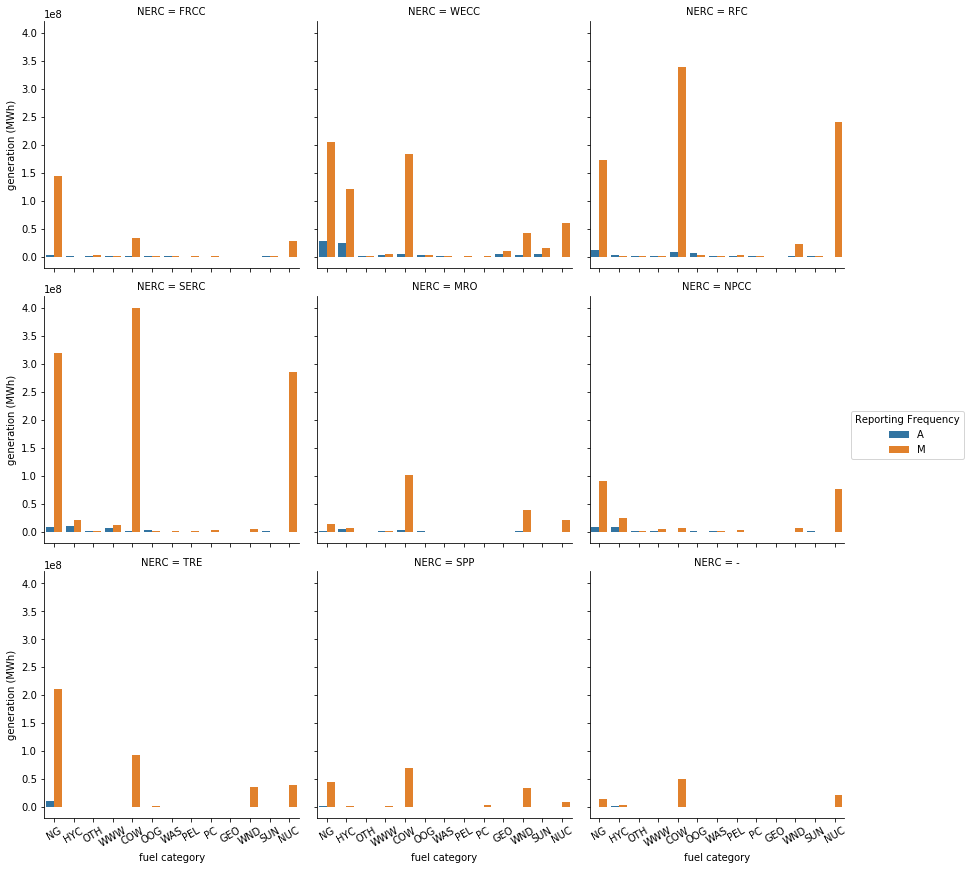

In [76]:
g = sns.factorplot(x='fuel category', y='generation (MWh)', hue='Reporting Frequency',
               col='NERC', col_wrap=3, data=df, estimator=np.sum, ci=0, kind='bar')

g.set_xticklabels(rotation=30)

Number of NERC regions in a state

In [75]:
df.loc[df['state'] == 'TX', 'NERC'].nunique()

3

### Fraction of generation/consumption from Annual reporting facilities in each NERC region of a state
This is development of a method that will be used to approximate the fraction of EIA-estimated generation and consumption within each state that gets apportioned to each NERC regions (when there is more than one). The idea is to take data from the most recent "final" EIA-923 and use the annual reporting facilities to approximate the divisions for more recent data. I still need to figure out if it's better to do the calculation by month within a year or just for the year as a whole.

Determining if it's better to do month-by-month vs a single value for the whole year will depend on if the share of generation/consumption from Annual reporting facilities in each NERC changes much over the course of the year. There is the potential for error either way, and maybe even differences by state. Annual is certainly simpler.

While looking at data for Texas, I've discovered that generation from Annual reporting facilities can be negative. Need to figure out how (if?) to deal with this...

In [159]:
def annual(df, state):
    """Return the percent of gen & consumption by fuel type in each NERC region
    for a state"""
    a = df.loc[(df.state == state) & 
                     (df['Reporting Frequency'] == 'A')].copy()
    a.drop(['plant id', 'year'], axis=1, inplace=True)
    a = a.groupby(['NERC', 'fuel category']).sum()
    
    fuels = set(a.index.get_level_values('fuel category'))
    
    temp_list = []
    for fuel in fuels:
        temp = (a.xs(fuel, level='fuel category')
                / a.xs(fuel, level='fuel category').sum())
        temp['fuel category'] = fuel
        temp_list.append(temp)
    
    result = pd.concat(temp_list)
    result.reset_index(inplace=True)
    result['state'] = state
    
    rename_cols = {'generation (MWh)': '% generation',
                   'total fuel (mmbtu)': '% total fuel',
                   'elec fuel (mmbtu)': '% elec fuel'}
    
    result.rename(columns=rename_cols, inplace=True)
    
    return result

In [210]:
def annual_month(df, state):
    """Return the percent of gen & consumption by fuel type and month in each 
    NERC region for a state"""
    a = df.loc[(df.state == state) & 
                     (df['Reporting Frequency'] == 'A')].copy()
    a.drop(['plant id', 'year'], axis=1, inplace=True)
    a = a.groupby(['NERC', 'fuel category', 'month']).sum()
    
    fuels = set(a.index.get_level_values('fuel category'))
    
    temp_list = []
    for fuel in fuels:
        for month in range(1, 13):
            temp = (a.xs(fuel, level='fuel category')
                     .xs(month, level='month')
                    / a.xs(fuel, level='fuel category')
                       .xs(month, level='month')
                       .sum())
            temp['fuel category'] = fuel
            temp['month'] = month
            temp_list.append(temp)
    
    result = pd.concat(temp_list)
    result.reset_index(inplace=True)
    result['state'] = state
    
    rename_cols = {'generation (MWh)': '% generation',
                   'total fuel (mmbtu)': '% total fuel',
                   'elec fuel (mmbtu)': '% elec fuel'}
    
    result.rename(columns=rename_cols, inplace=True)
    
    return result

This is the percent of generation, total fuel consumption, and electric fuel consumption from facilities that report annually to EIA-923

In [160]:
df_list = []
for state in states:
    num_nerc = df.loc[df.state == state, 'NERC'].nunique()
    if num_nerc > 1:
        df_list.append(annual(df, state))

In [211]:
df_list = []
for state in states:
    num_nerc = df.loc[df.state == state, 'NERC'].nunique()
    if num_nerc > 1:
        df_list.append(annual_month(df, state))

In [212]:
fuel_by_nerc_month = pd.concat(df_list).reset_index(drop=True)

In [161]:
fuel_by_nerc = pd.concat(df_list).reset_index(drop=True)

In [162]:
fuel_by_nerc.head()

,NERC,% generation,% total fuel,% elec fuel,fuel category,state
0,SERC,1.000000,1.000000,1.000000,WAS,AR
1,-,0.000000,0.000000,0.000000,PEL,AR
2,SERC,1.000000,1.000000,1.000000,PEL,AR
3,SERC,0.521641,0.525796,0.525796,OOG,AR
4,SPP,0.478359,0.474204,0.474204,OOG,AR


In [214]:
fuel_by_nerc_month.tail()

,NERC,% generation,% total fuel,% elec fuel,fuel category,month,state
2704,RFC,0.249526,0.382119,0.513470,NG,10,WI
2705,MRO,0.946647,0.666793,0.665857,NG,11,WI
2706,RFC,0.053353,0.333207,0.334143,NG,11,WI
2707,MRO,0.923901,0.658481,0.718664,NG,12,WI
2708,RFC,0.076099,0.341519,0.281336,NG,12,WI


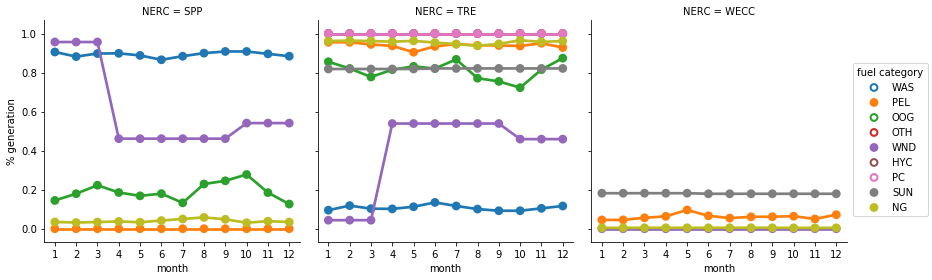

In [225]:
sns.factorplot(x='month', y='% generation', hue='fuel category', col='NERC',
               data=fuel_by_nerc_month.loc[(fuel_by_nerc_month.state=='TX') &
                                           (fuel_by_nerc_month['fuel category'] != 'WWW')],
               n_boot=1)

In [222]:
fuel_by_nerc_month.loc[(fuel_by_nerc_month.state=='TX') &
                       (fuel_by_nerc_month['fuel category'] == 'WWW')]

,NERC,% generation,% total fuel,% elec fuel,fuel category,month,state
2265,SPP,4.484362,0.538867,0.562231,WWW,1,TX
2266,TRE,-3.484362,0.461133,0.437769,WWW,1,TX
2267,SPP,4.132260,0.473945,0.564103,WWW,2,TX
2268,TRE,-3.132260,0.526055,0.435897,WWW,2,TX
2269,SPP,5.280268,0.519683,0.550018,WWW,3,TX
2270,TRE,-4.280268,0.480317,0.449982,WWW,3,TX
2271,SPP,2.961378,0.697669,0.725501,WWW,4,TX
2272,TRE,-1.961378,0.302331,0.274499,WWW,4,TX
2273,SPP,-5.065479,0.586754,0.959101,WWW,5,TX
2274,TRE,6.065479,0.413246,0.040899,WWW,5,TX


In [232]:
df.loc[(df.state == 'TX') &
       (df['fuel category'] == 'WWW') &
       (df['Reporting Frequency'] == 'A')].groupby(['NERC', 'month', 'fuel category']).sum()

year  plant id  generation (MWh)  \
NERC month fuel category                                     
SPP  1     WWW            6045    158335         24477.085   
     2     WWW            6045    158335         23591.727   
     3     WWW            6045    158335         23338.641   
     4     WWW            6045    158335         23981.906   
     5     WWW            6045    158335         22927.767   
     6     WWW            6045    158335         19081.413   
     7     WWW            6045    158335         22039.664   
     8     WWW            6045    158335         22143.524   
     9     WWW            6045    158335         22219.108   
     10    WWW            6045    158335         15374.204   
     11    WWW            6045    158335         22856.243   
     12    WWW            6045    158335         21888.202   
TRE  1     WWW            6045     75188        -19018.764   
     2     WWW            6045     75188        -17882.569   
     3     WWW            6045     75188        -18918.668   
     4     WWW            6045     75188        -15883.681   
     5     WWW            6045     75188        -27454.045   
     6     WWW            6045     75188        -13689.060   
     7     WWW            6045     75188        -18254.812   
     8     WWW            6045     75188        -14301.901   
     9     WWW            6045     75188        -17163.885   
     10    WWW            6045     75188        -16639.300   
     11    WWW            6045     75188        -18039.961   
     12    WWW            6045     75188        -15605.285   

                          total fuel (mmbtu)  elec fuel (mmbtu)  
NERC month fuel category                                         
SPP  1     WWW                     1031862.0           270598.0  
     2     WWW                     1002454.0           260114.0  
     3     WWW                     1055755.0           258287.0  
     4     WWW                     1079494.0           265683.0  
     5     WWW                     1020067.0           253919.0  
     6     WWW                      824972.0           210964.0  
     7     WWW                      994750.0           243501.0  
     8     WWW                     1014658.0           243921.0  
     9     WWW                     1071510.0           245327.0  
     10    WWW                      712726.0           169390.0  
     11    WWW                     1012581.0           253042.0  
     12    WWW                      964300.0           241652.0  
TRE  1     WWW                      883010.0           210695.0  
     2     WWW                     1112673.0           200997.0  
     3     WWW                      975783.0           211310.0  
     4     WWW                      467792.0           100523.0  
     5     WWW                      718424.0            10828.0  
     6     WWW                     1151472.0           110548.0  
     7     WWW                     1071581.0           178150.0  
     8     WWW                      856449.0           188369.0  
     9     WWW                      753512.0           182816.0  
     10    WWW                      440272.0           169733.0  
     11    WWW                      983507.0           220204.0  
     12    WWW                     1070104.0           190996.0

In [230]:
df.loc[(df.state == 'TX') &
       (df['fuel category'] == 'WWW') &
       (df['Reporting Frequency'] == 'A')].groupby(['NERC', 'fuel category']).sum()

,,year,month,plant id,generation (MWh),total fuel (mmbtu),elec fuel (mmbtu)
NERC,fuel category,,,,,,
SPP,WWW,72540,234,1900020,263919.484,11785129.0,2916398.0
TRE,WWW,72540,234,902256,-212851.931,10484579.0,1975169.0


#### States that include more than one NERC region

In [79]:
NERC_states = ['WY', 'SD', 'NE', 'OK', 'TX', 'NM', 'LA', 'AR',
               'MO', 'MN', 'IL', 'KY', 'VA', 'FL']

In [93]:
error_list = []
for state in NERC_states:
    error = (annual_state.loc[2016, state]
             - annual_facility.loc[2016, state]) / annual_state.loc[2016, state]
    error['state'] = state
    
    for col in ['generation (MWh)']:#, 'elec fuel (mmbtu)']:
        if error.loc[error[col] > 0.05, col].any():
            error_list.append(error.loc[error[col] > 0.05])

The dataframe below shows all states with more than one NERC region where facility generation is at least 5% below EIA's state-level estimate in 2016. 

In [94]:
pd.concat(error_list)

,generation (MWh),elec fuel (mmbtu),state
COW,0.057014,0.058988,WY
HYC,0.095835,NaN,WY
NG,0.413092,0.508736,WY
NG,0.212550,0.233675,SD
HYC,1.000000,NaN,NE
NG,0.141895,0.122942,NE
WAS,1.000000,NaN,NE
HYC,0.327894,NaN,OK
OTH,0.359396,NaN,OK
PEL,0.098354,0.089782,OK
